# Computational Modelling of Social Systems (SS) [706030] 

## Final Project 

### Group 26  

## Members & Mat. No :  
Pasindu Umayangana Gunasekara (12407710)
Jawarange Wikum Rumesh Jayalath (12408273)
Walimuni Dewage Sathsarani Kavindika Dharmasiri (12447858) 
Sanduni Thamali Wanigasinghe Wanigasinghe Weebadde Lekamalage (12444745)

Example 1: Comparing 1D and 2D Consensus Time (Periodic BC)

Simulating 1D, L=50, Periodic BC for 10 runs...
1D L=50 Avg Consensus Time: 9860.30 steps

Simulating 1D, L=100, Periodic BC for 10 runs...
1D L=100 Avg Consensus Time: 44638.40 steps

Simulating 1D, L=150, Periodic BC for 10 runs...
1D L=150 Avg Consensus Time: 50000.00 steps

Simulating 2D, L=10, Periodic BC for 10 runs...
2D L=10 Avg Consensus Time: 8974.20 steps

Simulating 2D, L=20, Periodic BC for 10 runs...
2D L=20 Avg Consensus Time: 50000.00 steps

Simulating 2D, L=30, Periodic BC for 10 runs...
2D L=30 Avg Consensus Time: 50000.00 steps


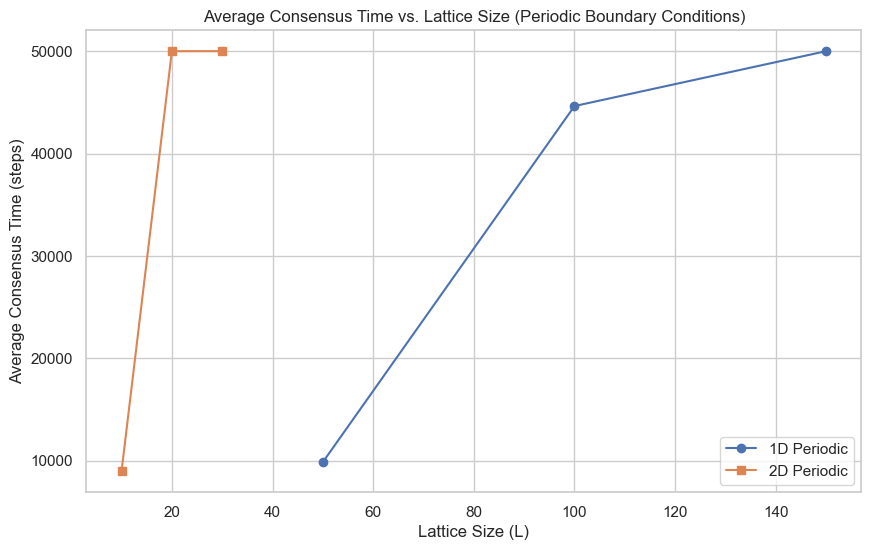


--- Example 2: Impact of Boundary Conditions on Interface Density (2D) ---

Simulating 2D, L=25, Periodic BC...


<Figure size 1200x600 with 0 Axes>

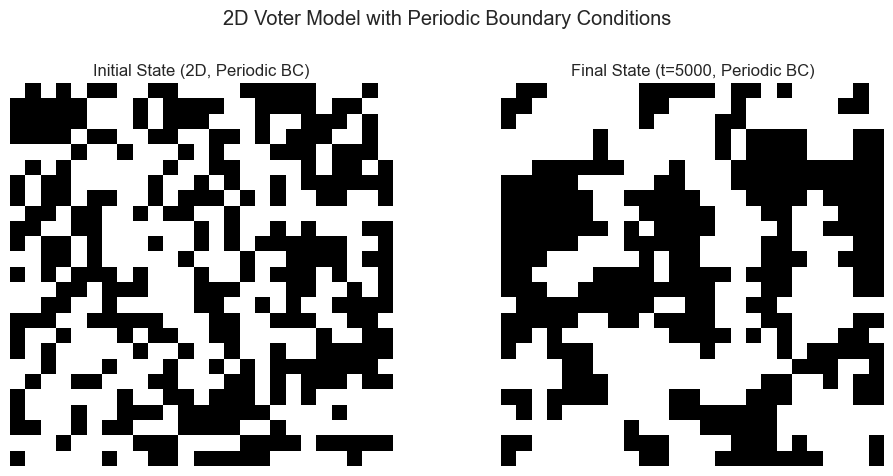


Simulating 2D, L=25, Fixed BC...


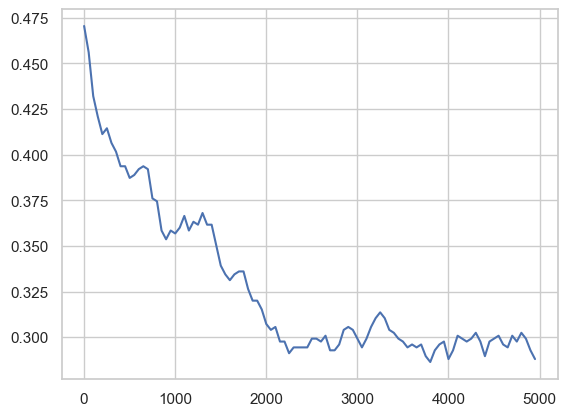

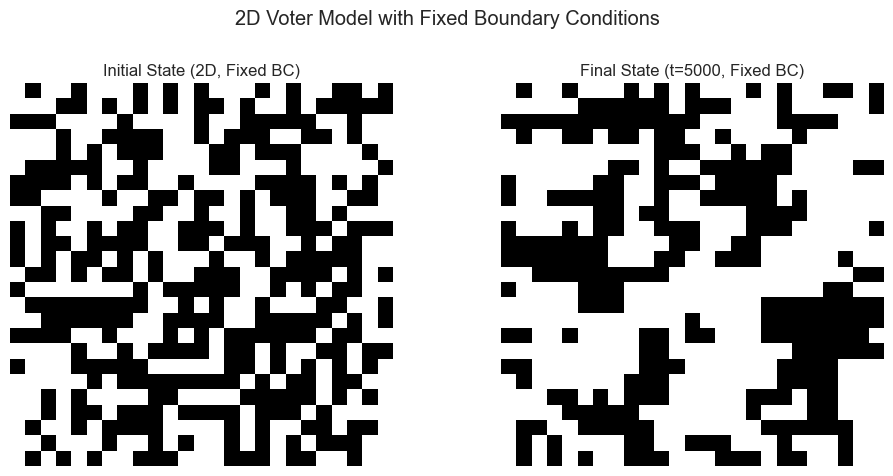


Simulating 2D, L=25, Open BC...


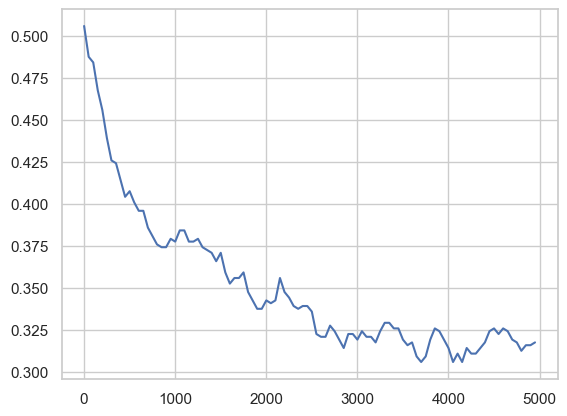

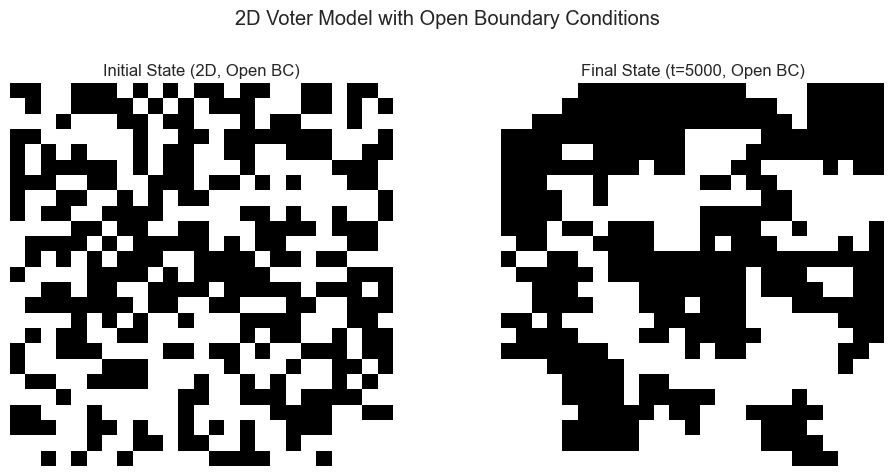

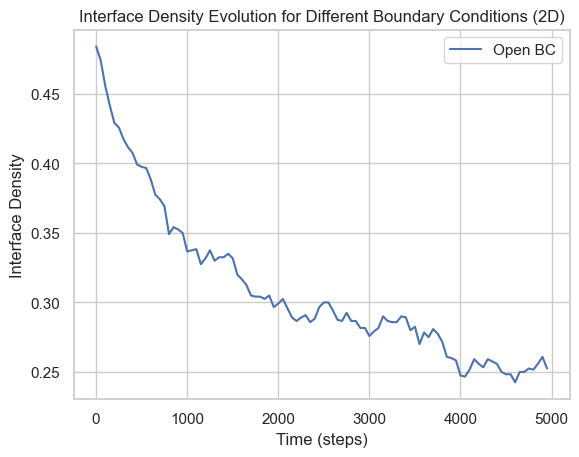


--- Example 3: Global Opinion Proportion & Cluster Analysis (1D Periodic) ---


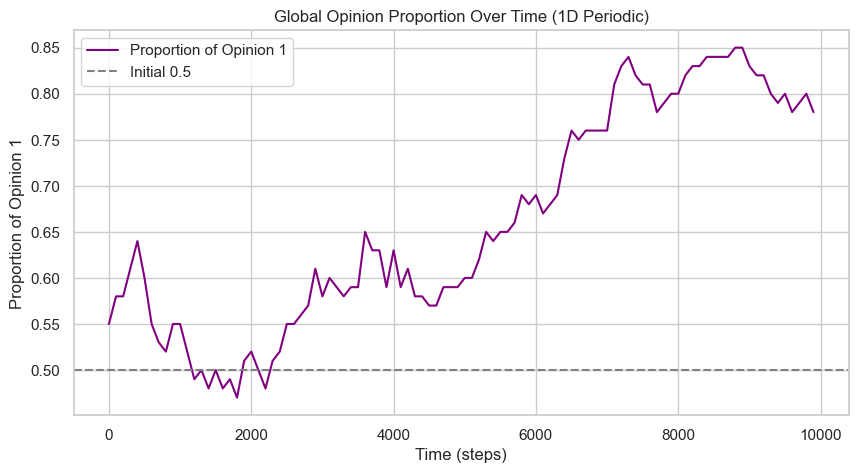


--- Cluster Analysis ---


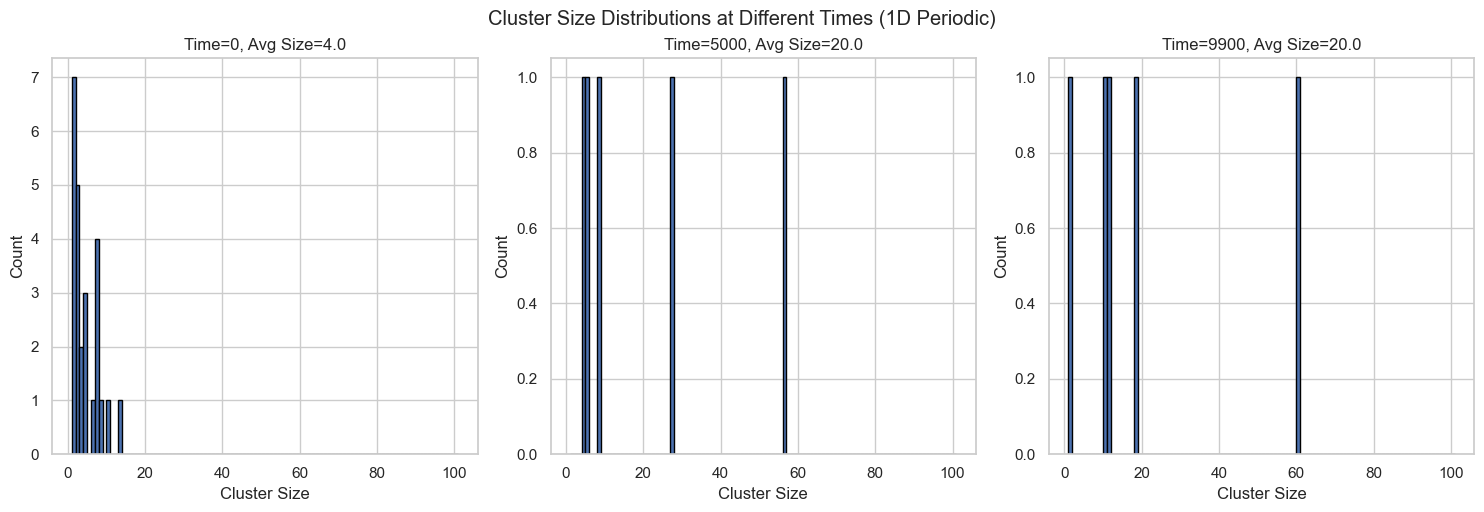


Simulation Complete. Final Consensus Time (if reached): 10000 steps


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from collections import defaultdict

# Set a consistent style for plots
sns.set_theme(style="whitegrid")

# Agent Class
class Agent:
   
    def __init__(self, agent_id, initial_state, position):
        self.id = agent_id
        self.state = initial_state  # 0 or 1 (e.g., 'white' or 'black' opinion)
        self.position = position    # (x,) for 1D, (x,y) for 2D
        self.neighbors = []         # List to store references to neighbor Agent objects

    def update_state(self, new_state):
        self.state = new_state

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor)

# Model Class 
class AgentBasedVoterModel:
    def __init__(self, lattice_size, dimensions=1, process_type='invasion', boundary_condition='periodic'):
        self.dimensions = dimensions
        self.lattice_size = lattice_size
        self.process_type = process_type
        self.boundary_condition = boundary_condition
        self.agents = []
        self.time = 0
        self.history = [] # Stores snapshots of the lattice configuration over time
        self.global_opinion_history = [] # Stores proportion of opinion 1 over time
        self.interface_density_history = [] # Stores interface density over time
        self.consensus_time = None # Stores the time (steps) when consensus is reached

        # Create agents and assign initial random states (approximately 50/50 split)
        # This represents our initial "demographic statistic" for the population.
        if dimensions == 1:
            for x in range(lattice_size):
                state = np.random.choice([0, 1])
                self.agents.append(Agent(x, state, (x,)))
        elif dimensions == 2:
            for x in range(lattice_size):
                for y in range(lattice_size):
                    state = np.random.choice([0, 1])
                    self.agents.append(Agent(x * lattice_size + y, state, (x, y)))
        else:
            raise ValueError("Dimensions must be 1 or 2.")

        # Set up neighborhood relationships based on the chosen boundary condition
        self._setup_neighborhoods()

        # Identify agents that can change their state (all except those on fixed boundaries)
        self.updatable_agents = [agent for agent in self.agents if not self._is_fixed_boundary_agent(agent)]

    def _is_fixed_boundary_agent(self, agent):
        if self.boundary_condition == 'fixed':
            if self.dimensions == 1:
                return agent.position[0] == 0 or agent.position[0] == self.lattice_size - 1
            elif self.dimensions == 2:
                x, y = agent.position
                return (x == 0 or x == self.lattice_size - 1 or
                        y == 0 or y == self.lattice_size - 1)
        return False

    def _setup_neighborhoods(self):
        for agent in self.agents:
            if self.dimensions == 1:
                x = agent.position[0]
                if self.boundary_condition == 'periodic':
                    # Neighbors wrap around (e.g., agent 0's left neighbor is last agent)
                    left_idx = (x - 1) % self.lattice_size
                    right_idx = (x + 1) % self.lattice_size
                    agent.add_neighbor(self.agents[left_idx])
                    agent.add_neighbor(self.agents[right_idx])
                elif self.boundary_condition == 'fixed' or self.boundary_condition == 'open':
                    # Neighbors are only within the lattice bounds
                    if x > 0: # Left neighbor
                        agent.add_neighbor(self.agents[x - 1])
                    if x < self.lattice_size - 1: # Right neighbor
                        agent.add_neighbor(self.agents[x + 1])
            elif self.dimensions == 2:
                x, y = agent.position
                # 4-neighbor (von Neumann) connectivity
                neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

                for dx, dy in neighbor_offsets:
                    nx, ny = x + dx, y + dy

                    if self.boundary_condition == 'periodic':
                        # Neighbors wrap around (e.g., top row connects to bottom row)
                        nx = nx % self.lattice_size
                        ny = ny % self.lattice_size
                        neighbor_id = nx * self.lattice_size + ny
                        agent.add_neighbor(self.agents[neighbor_id])
                    elif self.boundary_condition == 'fixed' or self.boundary_condition == 'open':
                        # Neighbors are only those within the lattice bounds
                        if 0 <= nx < self.lattice_size and 0 <= ny < self.lattice_size:
                            neighbor_id = nx * self.lattice_size + ny
                            agent.add_neighbor(self.agents[neighbor_id])

    def step(self):
        # If there are no updatable agents (e.g., a tiny lattice with all fixed boundaries),
        # simply increment time and return current config.
        if not self.updatable_agents:
            self.time += 1
            return self.get_current_configuration()

        # Select a random agent from the list of agents that can change their state
        agent = np.random.choice(self.updatable_agents)

        # Ensure the chosen agent has neighbors to interact with
        if not agent.neighbors:
            self.time += 1
            return self.get_current_configuration()

        # Select a random neighbor for interaction
        neighbor = np.random.choice(agent.neighbors)

        # Apply the chosen interaction process
        if self.process_type == 'invasion':
            # Standard voter model: the agent adopts the neighbor's state
            agent.update_state(neighbor.state)
        elif self.process_type == 'swapping':
            # Agent and neighbor swap their states
            agent.state, neighbor.state = neighbor.state, agent.state
        elif self.process_type == 'alternation':
            # Anti-alignment: if agent and neighbor have the same state, one flips randomly
            if agent.state == neighbor.state:
                if np.random.rand() < 0.5:
                    agent.update_state(1 - agent.state)
                else:
                    neighbor.update_state(1 - neighbor.state)

        self.time += 1 # Increment simulation time
        return self.get_current_configuration()

    def get_current_configuration(self):
        if self.dimensions == 1:
            # For 1D, return a simple array of states, sorted by agent ID (position)
            return np.array([a.state for a in sorted(self.agents, key=lambda x: x.id)])
        else:
            # For 2D, reconstruct the grid from agent positions and states
            size = self.lattice_size
            config = np.zeros((size, size))
            for agent in self.agents:
                x, y = agent.position
                config[x, y] = agent.state
            return config

    def get_global_opinion_proportion(self):
        current_config = self.get_current_configuration()
        return np.sum(current_config) / current_config.size

    def get_interface_density(self):
        config = self.get_current_configuration()
        if self.dimensions == 1:
            if self.boundary_condition == 'periodic':
                # Count differences between adjacent elements, including wrap-around
                return np.sum(config != np.roll(config, -1)) / self.lattice_size
            else: # Fixed or Open
                # Count differences between adjacent elements, excluding boundaries
                return np.sum(config[:-1] != config[1:]) / (self.lattice_size - 1)
        elif self.dimensions == 2:
            # Count horizontal interfaces (differences between (x,y) and (x,y+1))
            horiz_diff = config[:, :-1] != config[:, 1:]
            # Count vertical interfaces (differences between (x,y) and (x+1,y))
            vert_diff = config[:-1, :] != config[1:, :]

            if self.boundary_condition == 'periodic':
                # Add wrap-around differences for periodic boundaries
                horiz_diff_wrap = config[:, -1] != config[:, 0]
                vert_diff_wrap = config[-1, :] != config[0, :]
                
                total_interfaces = np.sum(horiz_diff) + np.sum(horiz_diff_wrap) + \
                                   np.sum(vert_diff) + np.sum(vert_diff_wrap)
                # Total possible interfaces in a periodic 2D grid (each agent has 4 bonds, divided by 2 for unique bonds)
                total_possible_interfaces = 2 * self.lattice_size * self.lattice_size
            else: # Fixed or Open
                total_interfaces = np.sum(horiz_diff) + np.sum(vert_diff)
                # Total possible interfaces in a non-periodic 2D grid
                total_possible_interfaces = 2 * self.lattice_size * (self.lattice_size - 1)
            
            # Avoid division by zero if lattice size is too small
            if total_possible_interfaces == 0:
                return 0
            return total_interfaces / total_possible_interfaces
        return 0 # Should not happen

    def simulate(self, steps, record_interval=1, check_consensus=True):
        self.history = []
        self.global_opinion_history = []
        self.interface_density_history = []
        self.consensus_time = None # Reset consensus time for new simulation run

        for i in range(steps):
            config = self.step()
            
            # Check for consensus (all 0s or all 1s)
            if check_consensus:
                if np.all(config == 0) or np.all(config == 1):
                    self.consensus_time = self.time
                    # Fill remaining history with the consensus state for consistent plotting
                    # This ensures plots extend to the full 'steps' duration if needed
                    for _ in range(i, steps):
                        if self.time % record_interval == 0:
                            self.history.append(config)
                            self.global_opinion_history.append(self.get_global_opinion_proportion())
                            self.interface_density_history.append(self.get_interface_density())
                        self.time += 1 # Ensure time continues incrementing even if not recording
                    break # Consensus reached, stop the simulation loop

            # Record data at specified intervals
            if self.time % record_interval == 0:
                self.history.append(config)
                self.global_opinion_history.append(self.get_global_opinion_proportion())
                self.interface_density_history.append(self.get_interface_density())
        
        # If simulation completes 'steps' without reaching consensus, set consensus_time to max steps
        if self.consensus_time is None:
            self.consensus_time = steps

        return {
            'history': self.history,
            'global_opinion_history': self.global_opinion_history,
            'interface_density_history': self.interface_density_history,
            'consensus_time': self.consensus_time
        }

# Cluster Analysis Function 
def analyze_clusters(lattice_config):
    if lattice_config.size == 0:
        return {'num_clusters': 0, 'avg_size': 0, 'size_dist': []}

    if lattice_config.ndim == 1:
        clusters = []
        if lattice_config.size == 0: # Handle empty lattice
            return {'num_clusters': 0, 'avg_size': 0, 'size_dist': []}

        # Iterate through the 1D array to find contiguous blocks
        current_state = lattice_config[0]
        current_size = 0
        for i in range(lattice_config.size):
            if lattice_config[i] == current_state:
                current_size += 1
            else:
                clusters.append(current_size)
                current_state = lattice_config[i]
                current_size = 1
        clusters.append(current_size) # Add the last cluster

        num_clusters = len(clusters)
        avg_size = np.mean(clusters) if clusters else 0
        return {'num_clusters': num_clusters, 'avg_size': avg_size, 'size_dist': clusters}

    elif lattice_config.ndim == 2:
        # For 2D, use a simple Breadth-First Search (BFS) or Depth-First Search (DFS)
        # to find connected components (clusters) of the same opinion.
        rows, cols = lattice_config.shape
        visited = np.zeros_like(lattice_config, dtype=bool) # Keep track of visited cells
        cluster_sizes = [] # Stores the size of each found cluster

        for r in range(rows):
            for c in range(cols):
                if not visited[r, c]: # If cell hasn't been visited, it's a new cluster
                    current_opinion = lattice_config[r, c]
                    size = 0
                    stack = [(r, c)] # Use a stack for DFS (or queue for BFS)
                    visited[r, c] = True

                    while stack:
                        cr, cc = stack.pop() # Current row, current column
                        size += 1
                        # Check 4 neighbors (up, down, left, right)
                        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nr, nc = cr + dr, cc + dc # Neighbor row, neighbor column
                            # Check if neighbor is within bounds, not visited, and has same opinion
                            if 0 <= nr < rows and 0 <= nc < cols and \
                                not visited[nr, nc] and lattice_config[nr, nc] == current_opinion:
                                visited[nr, nc] = True
                                stack.append((nr, nc)) # Add neighbor to stack for further exploration
                    cluster_sizes.append(size) # Store the size of the completed cluster
        
        num_clusters = len(cluster_sizes)
        avg_size = np.mean(cluster_sizes) if cluster_sizes else 0
        return {'num_clusters': num_clusters, 'avg_size': avg_size, 'size_dist': cluster_sizes}
    else:
        raise ValueError("Lattice configuration must be 1D or 2D.")

# Simulation and Visualization Examples 
# These examples demonstrate how to use the model and collect data
# They also provide basic visualizations as discussed in the research plan.

# Example 1: Comparing 1D and 2D Consensus Time (Q1 & Q3)
print("Example 1: Comparing 1D and 2D Consensus Time (Periodic BC)")
LATTICE_SIZES_1D = [50, 100, 150]
LATTICE_SIZES_2D = [10, 20, 30] # Smaller for 2D due to N^2 agents
MAX_STEPS = 50000 # Max steps for simulation
NUM_RUNS = 10 # Number of independent simulation runs for averaging

consensus_times_1d = {L: [] for L in LATTICE_SIZES_1D}
consensus_times_2d = {L: [] for L in LATTICE_SIZES_2D}

# Simulate 1D Voter Model with periodic boundary conditions
for L in LATTICE_SIZES_1D:
    print(f"\nSimulating 1D, L={L}, Periodic BC for {NUM_RUNS} runs...")
    for _ in range(NUM_RUNS):
        model_1d = AgentBasedVoterModel(lattice_size=L, dimensions=1, process_type='invasion', boundary_condition='periodic')
        results_1d = model_1d.simulate(MAX_STEPS, check_consensus=True)
        consensus_times_1d[L].append(results_1d['consensus_time'])
    print(f"1D L={L} Avg Consensus Time: {np.mean(consensus_times_1d[L]):.2f} steps")

# Simulate 2D Voter Model with periodic boundary conditions
for L in LATTICE_SIZES_2D:
    print(f"\nSimulating 2D, L={L}, Periodic BC for {NUM_RUNS} runs...")
    for _ in range(NUM_RUNS):
        model_2d = AgentBasedVoterModel(lattice_size=L, dimensions=2, process_type='invasion', boundary_condition='periodic')
        results_2d = model_2d.simulate(MAX_STEPS, check_consensus=True)
        consensus_times_2d[L].append(results_2d['consensus_time'])
    print(f"2D L={L} Avg Consensus Time: {np.mean(consensus_times_2d[L]):.2f} steps")

# Plotting Average Consensus Time vs. Lattice Size
plt.figure(figsize=(10, 6))
avg_times_1d = [np.mean(consensus_times_1d[L]) for L in LATTICE_SIZES_1D]
avg_times_2d = [np.mean(consensus_times_2d[L]) for L in LATTICE_SIZES_2D]

plt.plot(LATTICE_SIZES_1D, avg_times_1d, 'o-', label='1D Periodic')
plt.plot(LATTICE_SIZES_2D, avg_times_2d, 's-', label='2D Periodic')
plt.xlabel("Lattice Size (L)")
plt.ylabel("Average Consensus Time (steps)")
plt.title("Average Consensus Time vs. Lattice Size (Periodic Boundary Conditions)")
plt.legend()
plt.grid(True)
plt.show()


# Example 2: Impact of Boundary Conditions on Interface Density (Q2)
print("\n--- Example 2: Impact of Boundary Conditions on Interface Density (2D) ---")
L_2D_BC = 25 # Fixed lattice size for BC comparison
MAX_STEPS_BC = 5000 # Shorter simulation for density evolution
BC_TYPES = ['periodic', 'fixed', 'open']

plt.figure(figsize=(12, 6))

for bc_type in BC_TYPES:
    print(f"\nSimulating 2D, L={L_2D_BC}, {bc_type.capitalize()} BC...")
    # Run a single simulation for demonstration of density evolution
    model_bc = AgentBasedVoterModel(lattice_size=L_2D_BC, dimensions=2, process_type='invasion', boundary_condition=bc_type)
    results_bc = model_bc.simulate(MAX_STEPS_BC, record_interval=50, check_consensus=False) # Don't stop early for density plot

    # Plot initial and final states for visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(results_bc['history'][0], cmap='binary')
    axes[0].set_title(f"Initial State (2D, {bc_type.capitalize()} BC)")
    axes[0].axis('off')

    axes[1].imshow(results_bc['history'][-1], cmap='binary')
    axes[1].set_title(f"Final State (t={model_bc.time}, {bc_type.capitalize()} BC)")
    axes[1].axis('off')
    plt.suptitle(f"2D Voter Model with {bc_type.capitalize()} Boundary Conditions")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Plot interface density over time
    time_points = [t * 50 for t in range(len(results_bc['interface_density_history']))]
    plt.plot(time_points, results_bc['interface_density_history'], label=f'{bc_type.capitalize()} BC')

plt.xlabel("Time (steps)")
plt.ylabel("Interface Density")
plt.title("Interface Density Evolution for Different Boundary Conditions (2D)")
plt.legend()
plt.grid(True)
plt.show()


# --- Example 3: Global Opinion Proportion & Cluster Analysis (Q1 & Q3) ---
print("\n--- Example 3: Global Opinion Proportion & Cluster Analysis (1D Periodic) ---")
L_1D_ANALYSIS = 100
MAX_STEPS_ANALYSIS = 10000
RECORD_INTERVAL_ANALYSIS = 100

model_analysis = AgentBasedVoterModel(lattice_size=L_1D_ANALYSIS, dimensions=1, process_type='invasion', boundary_condition='periodic')
results_analysis = model_analysis.simulate(MAX_STEPS_ANALYSIS, record_interval=RECORD_INTERVAL_ANALYSIS, check_consensus=True)

# Plot Global Opinion Proportion over Time
plt.figure(figsize=(10, 5))
time_points_analysis = [t * RECORD_INTERVAL_ANALYSIS for t in range(len(results_analysis['global_opinion_history']))]
plt.plot(time_points_analysis, results_analysis['global_opinion_history'], label='Proportion of Opinion 1', color='purple')
plt.xlabel("Time (steps)")
plt.ylabel("Proportion of Opinion 1")
plt.title("Global Opinion Proportion Over Time (1D Periodic)")
plt.axhline(y=0.5, color='gray', linestyle='--', label='Initial 0.5')
plt.legend()
plt.grid(True)
plt.show()

# Analyze and plot cluster size distributions at different time points
print("\n--- Cluster Analysis ---")
cluster_stats_times = [0, len(results_analysis['history']) // 2, len(results_analysis['history']) - 1]
cluster_stats_data = []

for t_idx in cluster_stats_times:
    config = results_analysis['history'][t_idx]
    stats = analyze_clusters(config)
    stats['time'] = t_idx * RECORD_INTERVAL_ANALYSIS
    cluster_stats_data.append(stats)

plt.figure(figsize=(15, 5))
for i, stats in enumerate(cluster_stats_data):
    plt.subplot(1, 3, i + 1)
    if stats['size_dist']: # Ensure there are clusters to plot
        plt.hist(stats['size_dist'], bins=np.arange(1, L_1D_ANALYSIS + 2), edgecolor='black')
    plt.title(f"Time={stats['time']}, Avg Size={stats['avg_size']:.1f}")
    plt.xlabel("Cluster Size")
    plt.ylabel("Count")
plt.tight_layout()
plt.suptitle("Cluster Size Distributions at Different Times (1D Periodic)", y=1.02)
plt.show()

print(f"\nSimulation Complete. Final Consensus Time (if reached): {model_analysis.consensus_time} steps")


--- Example 1: Comparing 1D and 2D Consensus Time (Periodic BC) ---

Simulating 1D, L=50, Periodic BC for 10 runs...
1D L=50 Avg Consensus Time: 11233.30 steps

Simulating 1D, L=100, Periodic BC for 10 runs...
1D L=100 Avg Consensus Time: 43376.00 steps

Simulating 1D, L=150, Periodic BC for 10 runs...
1D L=150 Avg Consensus Time: 50000.00 steps

Simulating 2D, L=10, Periodic BC for 10 runs...
2D L=10 Avg Consensus Time: 14269.20 steps

Simulating 2D, L=20, Periodic BC for 10 runs...
2D L=20 Avg Consensus Time: 50000.00 steps

Simulating 2D, L=30, Periodic BC for 10 runs...
2D L=30 Avg Consensus Time: 50000.00 steps


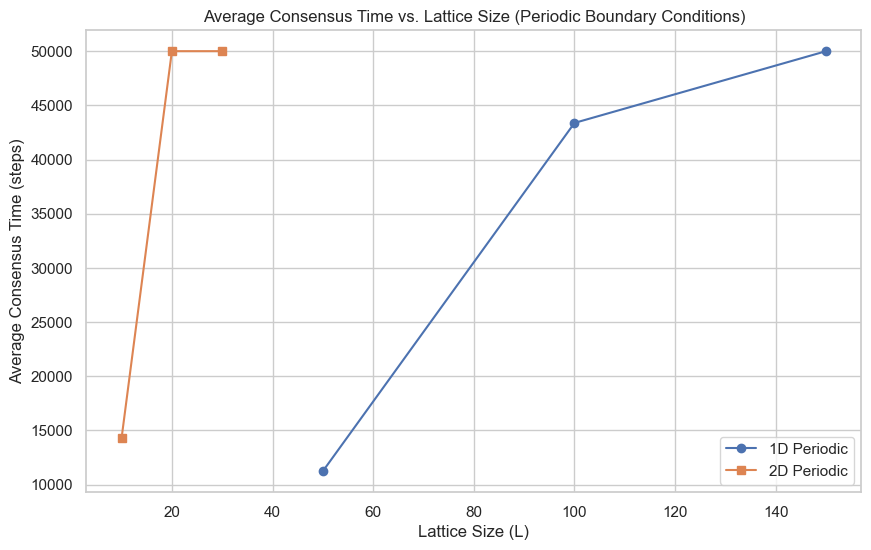


--- Example 2: Impact of Boundary Conditions on Interface Density (2D) ---

Simulating 2D, L=25, Periodic BC...


<Figure size 1200x600 with 0 Axes>

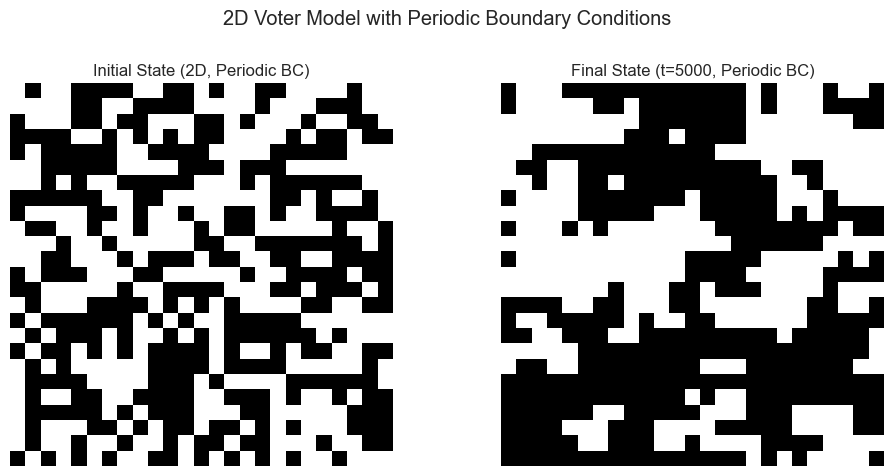


Simulating 2D, L=25, Fixed BC...


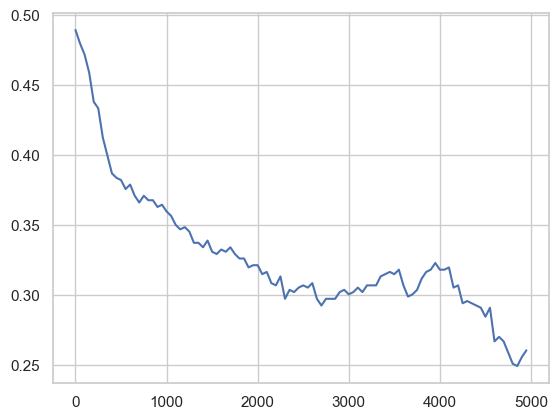

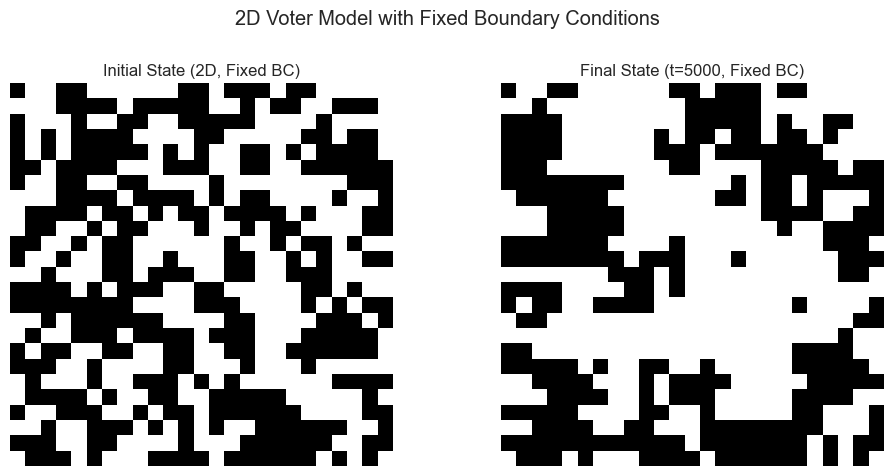


Simulating 2D, L=25, Open BC...


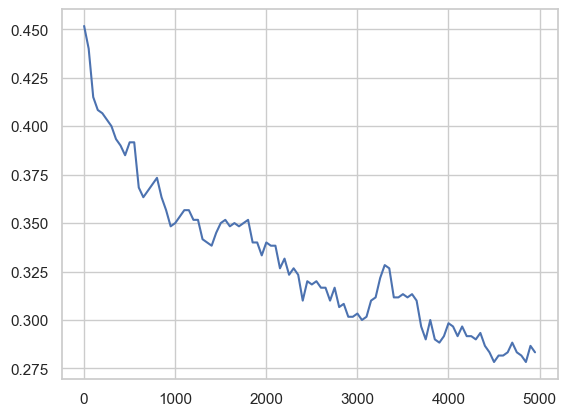

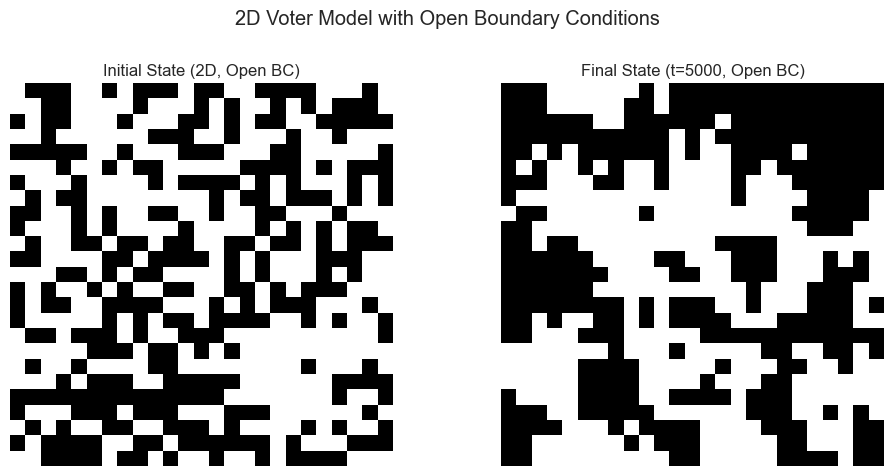

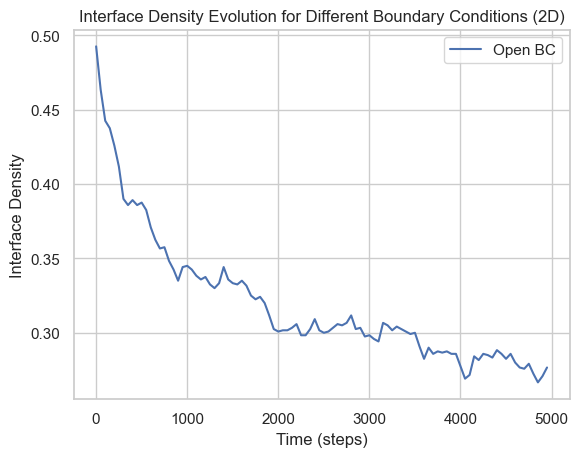


--- Example 3: Global Opinion Proportion & Cluster Analysis (1D Periodic) ---


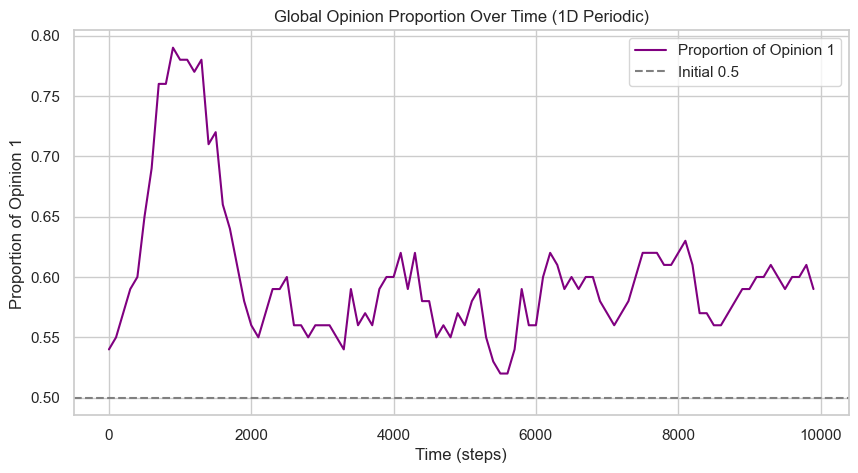


--- Cluster Analysis ---


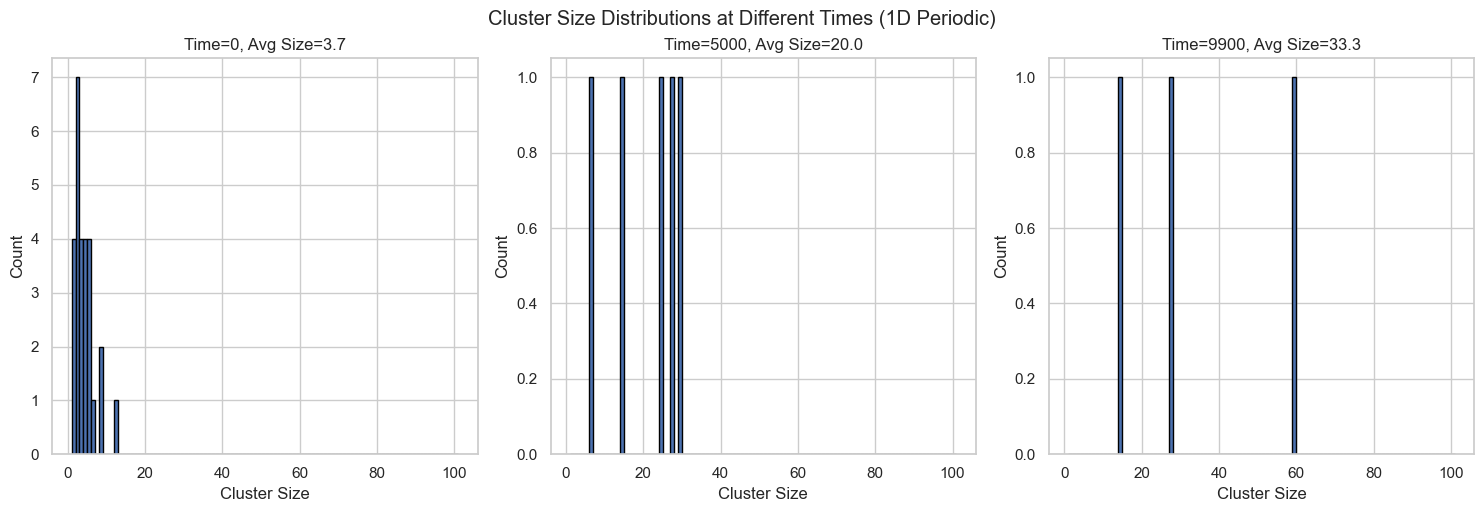


Simulation Complete. Final Consensus Time (if reached): 10000 steps


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from collections import defaultdict

# Set a consistent style for plots
sns.set_theme(style="whitegrid")

# --- Agent Class ---
class Agent:
    """
    Represents an individual agent (voter) in the simulation.
    Each agent has an ID, a binary opinion state (0 or 1), a position on the lattice,
    and a list of its neighbors.
    """
    def __init__(self, agent_id, initial_state, position):
        self.id = agent_id
        self.state = initial_state  # 0 or 1 (e.g., 'white' or 'black' opinion)
        self.position = position    # (x,) for 1D, (x,y) for 2D
        self.neighbors = []         # List to store references to neighbor Agent objects

    def update_state(self, new_state):
        """Updates the agent's opinion state."""
        self.state = new_state

    def add_neighbor(self, neighbor):
        """Adds a neighbor to the agent's list of neighbors."""
        self.neighbors.append(neighbor)

# --- Model Class ---
class AgentBasedVoterModel:
    """
    Implements the Agent-Based Voter Model.
    Supports 1D and 2D lattices, different interaction processes, and boundary conditions.
    """
    def __init__(self, lattice_size, dimensions=1, process_type='invasion', boundary_condition='periodic'):
        """
        Initializes the Agent-Based Voter Model.

        Args:
            lattice_size (int): The size of one side of the lattice. For 1D, it's the length.
                                For 2D, it's the side length of a square grid (e.g., 25 for a 25x25 grid).
            dimensions (int): The number of dimensions (1 or 2).
            process_type (str): The interaction rule ('invasion', 'swapping', or 'alternation').
                                'invasion': Agent adopts neighbor's state (standard Voter Model).
                                'swapping': Agent and neighbor exchange states.
                                'alternation': Similar neighbors become dissimilar (anti-alignment).
            boundary_condition (str): The type of boundary condition ('periodic', 'fixed', 'open').
                                    'periodic': Edges wrap around.
                                    'fixed': Agents at boundaries have fixed opinions.
                                    'open': Agents at boundaries have fewer neighbors; no wrap-around.
        """
        self.dimensions = dimensions
        self.lattice_size = lattice_size
        self.process_type = process_type
        self.boundary_condition = boundary_condition
        self.agents = []
        self.time = 0
        self.history = [] # Stores snapshots of the lattice configuration over time
        self.global_opinion_history = [] # Stores proportion of opinion 1 over time
        self.interface_density_history = [] # Stores interface density over time
        self.consensus_time = None # Stores the time (steps) when consensus is reached

        # Create agents and assign initial random states (approximately 50/50 split)
        # This represents our initial "demographic statistic" for the population.
        if dimensions == 1:
            for x in range(lattice_size):
                state = np.random.choice([0, 1])
                self.agents.append(Agent(x, state, (x,)))
        elif dimensions == 2:
            for x in range(lattice_size):
                for y in range(lattice_size):
                    state = np.random.choice([0, 1])
                    self.agents.append(Agent(x * lattice_size + y, state, (x, y)))
        else:
            raise ValueError("Dimensions must be 1 or 2.")

        # Set up neighborhood relationships based on the chosen boundary condition
        self._setup_neighborhoods()

        # Identify agents that can change their state (all except those on fixed boundaries)
        self.updatable_agents = [agent for agent in self.agents if not self._is_fixed_boundary_agent(agent)]

    def _is_fixed_boundary_agent(self, agent):
        """
        Helper method to check if an agent is located on a fixed boundary.
        Fixed boundary agents do not change their state during simulation.
        """
        if self.boundary_condition == 'fixed':
            if self.dimensions == 1:
                return agent.position[0] == 0 or agent.position[0] == self.lattice_size - 1
            elif self.dimensions == 2:
                x, y = agent.position
                return (x == 0 or x == self.lattice_size - 1 or
                        y == 0 or y == self.lattice_size - 1)
        return False

    def _setup_neighborhoods(self):
        """
        Connects agents to their neighbors based on dimensions and boundary conditions.
        Defines the interaction topology of the lattice.
        """
        for agent in self.agents:
            if self.dimensions == 1:
                x = agent.position[0]
                if self.boundary_condition == 'periodic':
                    # Neighbors wrap around (e.g., agent 0's left neighbor is last agent)
                    left_idx = (x - 1) % self.lattice_size
                    right_idx = (x + 1) % self.lattice_size
                    agent.add_neighbor(self.agents[left_idx])
                    agent.add_neighbor(self.agents[right_idx])
                elif self.boundary_condition == 'fixed' or self.boundary_condition == 'open':
                    # Neighbors are only within the lattice bounds
                    if x > 0: # Left neighbor
                        agent.add_neighbor(self.agents[x - 1])
                    if x < self.lattice_size - 1: # Right neighbor
                        agent.add_neighbor(self.agents[x + 1])
            elif self.dimensions == 2:
                x, y = agent.position
                # 4-neighbor (von Neumann) connectivity
                neighbor_offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

                for dx, dy in neighbor_offsets:
                    nx, ny = x + dx, y + dy

                    if self.boundary_condition == 'periodic':
                        # Neighbors wrap around (e.g., top row connects to bottom row)
                        nx = nx % self.lattice_size
                        ny = ny % self.lattice_size
                        neighbor_id = nx * self.lattice_size + ny
                        agent.add_neighbor(self.agents[neighbor_id])
                    elif self.boundary_condition == 'fixed' or self.boundary_condition == 'open':
                        # Neighbors are only those within the lattice bounds
                        if 0 <= nx < self.lattice_size and 0 <= ny < self.lattice_size:
                            neighbor_id = nx * self.lattice_size + ny
                            agent.add_neighbor(self.agents[neighbor_id])

    def step(self):
        """
        Performs one update step of the model.
        A random updatable agent is chosen and interacts with a random neighbor.
        """
        # If there are no updatable agents (e.g., a tiny lattice with all fixed boundaries),
        # simply increment time and return current config.
        if not self.updatable_agents:
            self.time += 1
            return self.get_current_configuration()

        # Select a random agent from the list of agents that can change their state
        agent = np.random.choice(self.updatable_agents)

        # Ensure the chosen agent has neighbors to interact with
        if not agent.neighbors:
            self.time += 1
            return self.get_current_configuration()

        # Select a random neighbor for interaction
        neighbor = np.random.choice(agent.neighbors)

        # Apply the chosen interaction process
        if self.process_type == 'invasion':
            # Standard voter model: the agent adopts the neighbor's state
            agent.update_state(neighbor.state)
        elif self.process_type == 'swapping':
            # Agent and neighbor swap their states
            agent.state, neighbor.state = neighbor.state, agent.state
        elif self.process_type == 'alternation':
            # Anti-alignment: if agent and neighbor have the same state, one flips randomly
            if agent.state == neighbor.state:
                if np.random.rand() < 0.5:
                    agent.update_state(1 - agent.state)
                else:
                    neighbor.update_state(1 - neighbor.state)

        self.time += 1 # Increment simulation time
        return self.get_current_configuration()

    def get_current_configuration(self):
        """Returns the current lattice configuration as a NumPy array."""
        if self.dimensions == 1:
            # For 1D, return a simple array of states, sorted by agent ID (position)
            return np.array([a.state for a in sorted(self.agents, key=lambda x: x.id)])
        else:
            # For 2D, reconstruct the grid from agent positions and states
            size = self.lattice_size
            config = np.zeros((size, size))
            for agent in self.agents:
                x, y = agent.position
                config[x, y] = agent.state
            return config

    def get_global_opinion_proportion(self):
        """
        Calculates the proportion of agents holding opinion 1 (e.g., 'black').
        This is a key macroscopic metric for tracking consensus.
        """
        current_config = self.get_current_configuration()
        return np.sum(current_config) / current_config.size

    def get_interface_density(self):
        """
        Calculates the density of interfaces (boundaries between different opinions).
        This quantifies the 'disorder' or 'fragmentation' of opinions.
        """
        config = self.get_current_configuration()
        if self.dimensions == 1:
            if self.boundary_condition == 'periodic':
                # Count differences between adjacent elements, including wrap-around
                return np.sum(config != np.roll(config, -1)) / self.lattice_size
            else: # Fixed or Open
                # Count differences between adjacent elements, excluding boundaries
                return np.sum(config[:-1] != config[1:]) / (self.lattice_size - 1)
        elif self.dimensions == 2:
            # Count horizontal interfaces (differences between (x,y) and (x,y+1))
            horiz_diff = config[:, :-1] != config[:, 1:]
            # Count vertical interfaces (differences between (x,y) and (x+1,y))
            vert_diff = config[:-1, :] != config[1:, :]

            if self.boundary_condition == 'periodic':
                # Add wrap-around differences for periodic boundaries
                horiz_diff_wrap = config[:, -1] != config[:, 0]
                vert_diff_wrap = config[-1, :] != config[0, :]
                
                total_interfaces = np.sum(horiz_diff) + np.sum(horiz_diff_wrap) + \
                                   np.sum(vert_diff) + np.sum(vert_diff_wrap)
                # Total possible interfaces in a periodic 2D grid (each agent has 4 bonds, divided by 2 for unique bonds)
                total_possible_interfaces = 2 * self.lattice_size * self.lattice_size
            else: # Fixed or Open
                total_interfaces = np.sum(horiz_diff) + np.sum(vert_diff)
                # Total possible interfaces in a non-periodic 2D grid
                total_possible_interfaces = 2 * self.lattice_size * (self.lattice_size - 1)
            
            # Avoid division by zero if lattice size is too small
            if total_possible_interfaces == 0:
                return 0
            return total_interfaces / total_possible_interfaces
        return 0 # Should not happen

    def simulate(self, steps, record_interval=1, check_consensus=True):
        """
        Runs the simulation for a given number of steps.
        Collects history, global opinion proportion, and interface density.
        Records consensus time if consensus is reached.

        Args:
            steps (int): The total number of simulation steps to run.
            record_interval (int): How often to record the lattice configuration and metrics.
            check_consensus (bool): If True, stops simulation early if consensus is reached.
        
        Returns:
            dict: Contains lists of historical data and the consensus time.
        """
        self.history = []
        self.global_opinion_history = []
        self.interface_density_history = []
        self.consensus_time = None # Reset consensus time for new simulation run

        for i in range(steps):
            config = self.step()
            
            # Check for consensus (all 0s or all 1s)
            if check_consensus:
                if np.all(config == 0) or np.all(config == 1):
                    self.consensus_time = self.time
                    # Fill remaining history with the consensus state for consistent plotting
                    # This ensures plots extend to the full 'steps' duration if needed
                    for _ in range(i, steps):
                        if self.time % record_interval == 0:
                            self.history.append(config)
                            self.global_opinion_history.append(self.get_global_opinion_proportion())
                            self.interface_density_history.append(self.get_interface_density())
                        self.time += 1 # Ensure time continues incrementing even if not recording
                    break # Consensus reached, stop the simulation loop

            # Record data at specified intervals
            if self.time % record_interval == 0:
                self.history.append(config)
                self.global_opinion_history.append(self.get_global_opinion_proportion())
                self.interface_density_history.append(self.get_interface_density())
        
        # If simulation completes 'steps' without reaching consensus, set consensus_time to max steps
        if self.consensus_time is None:
            self.consensus_time = steps

        return {
            'history': self.history,
            'global_opinion_history': self.global_opinion_history,
            'interface_density_history': self.interface_density_history,
            'consensus_time': self.consensus_time
        }

# --- Cluster Analysis Function ---
def analyze_clusters(lattice_config):
    """
    Analyzes clusters (contiguous blocks of same opinion) in a 1D or 2D lattice configuration.
    For 2D, uses a basic connected components algorithm.

    Args:
        lattice_config (np.array): The 1D or 2D NumPy array representing the lattice state.

    Returns:
        dict: Contains 'num_clusters', 'avg_size', and 'size_dist' (list of cluster sizes).
    """
    if lattice_config.size == 0:
        return {'num_clusters': 0, 'avg_size': 0, 'size_dist': []}

    if lattice_config.ndim == 1:
        clusters = []
        if lattice_config.size == 0: # Handle empty lattice
            return {'num_clusters': 0, 'avg_size': 0, 'size_dist': []}

        # Iterate through the 1D array to find contiguous blocks
        current_state = lattice_config[0]
        current_size = 0
        for i in range(lattice_config.size):
            if lattice_config[i] == current_state:
                current_size += 1
            else:
                clusters.append(current_size)
                current_state = lattice_config[i]
                current_size = 1
        clusters.append(current_size) # Add the last cluster

        num_clusters = len(clusters)
        avg_size = np.mean(clusters) if clusters else 0
        return {'num_clusters': num_clusters, 'avg_size': avg_size, 'size_dist': clusters}

    elif lattice_config.ndim == 2:
        # For 2D, use a simple Breadth-First Search (BFS) or Depth-First Search (DFS)
        # to find connected components (clusters) of the same opinion.
        rows, cols = lattice_config.shape
        visited = np.zeros_like(lattice_config, dtype=bool) # Keep track of visited cells
        cluster_sizes = [] # Stores the size of each found cluster

        for r in range(rows):
            for c in range(cols):
                if not visited[r, c]: # If cell hasn't been visited, it's a new cluster
                    current_opinion = lattice_config[r, c]
                    size = 0
                    stack = [(r, c)] # Use a stack for DFS (or queue for BFS)
                    visited[r, c] = True

                    while stack:
                        cr, cc = stack.pop() # Current row, current column
                        size += 1
                        # Check 4 neighbors (up, down, left, right)
                        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nr, nc = cr + dr, cc + dc # Neighbor row, neighbor column
                            # Check if neighbor is within bounds, not visited, and has same opinion
                            if 0 <= nr < rows and 0 <= nc < cols and \
                                not visited[nr, nc] and lattice_config[nr, nc] == current_opinion:
                                visited[nr, nc] = True
                                stack.append((nr, nc)) # Add neighbor to stack for further exploration
                    cluster_sizes.append(size) # Store the size of the completed cluster
        
        num_clusters = len(cluster_sizes)
        avg_size = np.mean(cluster_sizes) if cluster_sizes else 0
        return {'num_clusters': num_clusters, 'avg_size': avg_size, 'size_dist': cluster_sizes}
    else:
        raise ValueError("Lattice configuration must be 1D or 2D.")

# --- Simulation and Visualization Examples ---
# These examples demonstrate how to use the model and collect data
# They also provide basic visualizations as discussed in the research plan.

# --- Example 1: Comparing 1D and 2D Consensus Time (Q1 & Q3) ---
print("--- Example 1: Comparing 1D and 2D Consensus Time (Periodic BC) ---")
LATTICE_SIZES_1D = [50, 100, 150]
LATTICE_SIZES_2D = [10, 20, 30] # Smaller for 2D due to N^2 agents
MAX_STEPS = 50000 # Max steps for simulation
NUM_RUNS = 10 # Number of independent simulation runs for averaging

consensus_times_1d = {L: [] for L in LATTICE_SIZES_1D}
consensus_times_2d = {L: [] for L in LATTICE_SIZES_2D}

# Simulate 1D Voter Model with periodic boundary conditions
for L in LATTICE_SIZES_1D:
    print(f"\nSimulating 1D, L={L}, Periodic BC for {NUM_RUNS} runs...")
    for _ in range(NUM_RUNS):
        model_1d = AgentBasedVoterModel(lattice_size=L, dimensions=1, process_type='invasion', boundary_condition='periodic')
        results_1d = model_1d.simulate(MAX_STEPS, check_consensus=True)
        consensus_times_1d[L].append(results_1d['consensus_time'])
    print(f"1D L={L} Avg Consensus Time: {np.mean(consensus_times_1d[L]):.2f} steps")

# Simulate 2D Voter Model with periodic boundary conditions
for L in LATTICE_SIZES_2D:
    print(f"\nSimulating 2D, L={L}, Periodic BC for {NUM_RUNS} runs...")
    for _ in range(NUM_RUNS):
        model_2d = AgentBasedVoterModel(lattice_size=L, dimensions=2, process_type='invasion', boundary_condition='periodic')
        results_2d = model_2d.simulate(MAX_STEPS, check_consensus=True)
        consensus_times_2d[L].append(results_2d['consensus_time'])
    print(f"2D L={L} Avg Consensus Time: {np.mean(consensus_times_2d[L]):.2f} steps")

# Plotting Average Consensus Time vs. Lattice Size
plt.figure(figsize=(10, 6))
avg_times_1d = [np.mean(consensus_times_1d[L]) for L in LATTICE_SIZES_1D]
avg_times_2d = [np.mean(consensus_times_2d[L]) for L in LATTICE_SIZES_2D]

plt.plot(LATTICE_SIZES_1D, avg_times_1d, 'o-', label='1D Periodic')
plt.plot(LATTICE_SIZES_2D, avg_times_2d, 's-', label='2D Periodic')
plt.xlabel("Lattice Size (L)")
plt.ylabel("Average Consensus Time (steps)")
plt.title("Average Consensus Time vs. Lattice Size (Periodic Boundary Conditions)")
plt.legend()
plt.grid(True)
plt.show()


# --- Example 2: Impact of Boundary Conditions on Interface Density (Q2) ---
print("\n--- Example 2: Impact of Boundary Conditions on Interface Density (2D) ---")
L_2D_BC = 25 # Fixed lattice size for BC comparison
MAX_STEPS_BC = 5000 # Shorter simulation for density evolution
BC_TYPES = ['periodic', 'fixed', 'open']

plt.figure(figsize=(12, 6))

for bc_type in BC_TYPES:
    print(f"\nSimulating 2D, L={L_2D_BC}, {bc_type.capitalize()} BC...")
    # Run a single simulation for demonstration of density evolution
    model_bc = AgentBasedVoterModel(lattice_size=L_2D_BC, dimensions=2, process_type='invasion', boundary_condition=bc_type)
    results_bc = model_bc.simulate(MAX_STEPS_BC, record_interval=50, check_consensus=False) # Don't stop early for density plot

    # Plot initial and final states for visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(results_bc['history'][0], cmap='binary')
    axes[0].set_title(f"Initial State (2D, {bc_type.capitalize()} BC)")
    axes[0].axis('off')

    axes[1].imshow(results_bc['history'][-1], cmap='binary')
    axes[1].set_title(f"Final State (t={model_bc.time}, {bc_type.capitalize()} BC)")
    axes[1].axis('off')
    plt.suptitle(f"2D Voter Model with {bc_type.capitalize()} Boundary Conditions")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Plot interface density over time
    time_points = [t * 50 for t in range(len(results_bc['interface_density_history']))]
    plt.plot(time_points, results_bc['interface_density_history'], label=f'{bc_type.capitalize()} BC')

plt.xlabel("Time (steps)")
plt.ylabel("Interface Density")
plt.title("Interface Density Evolution for Different Boundary Conditions (2D)")
plt.legend()
plt.grid(True)
plt.show()


# --- Example 3: Global Opinion Proportion & Cluster Analysis (Q1 & Q3) ---
print("\n--- Example 3: Global Opinion Proportion & Cluster Analysis (1D Periodic) ---")
L_1D_ANALYSIS = 100
MAX_STEPS_ANALYSIS = 10000
RECORD_INTERVAL_ANALYSIS = 100

model_analysis = AgentBasedVoterModel(lattice_size=L_1D_ANALYSIS, dimensions=1, process_type='invasion', boundary_condition='periodic')
results_analysis = model_analysis.simulate(MAX_STEPS_ANALYSIS, record_interval=RECORD_INTERVAL_ANALYSIS, check_consensus=True)

# Plot Global Opinion Proportion over Time
plt.figure(figsize=(10, 5))
time_points_analysis = [t * RECORD_INTERVAL_ANALYSIS for t in range(len(results_analysis['global_opinion_history']))]
plt.plot(time_points_analysis, results_analysis['global_opinion_history'], label='Proportion of Opinion 1', color='purple')
plt.xlabel("Time (steps)")
plt.ylabel("Proportion of Opinion 1")
plt.title("Global Opinion Proportion Over Time (1D Periodic)")
plt.axhline(y=0.5, color='gray', linestyle='--', label='Initial 0.5')
plt.legend()
plt.grid(True)
plt.show()

# Analyze and plot cluster size distributions at different time points
print("\n--- Cluster Analysis ---")
cluster_stats_times = [0, len(results_analysis['history']) // 2, len(results_analysis['history']) - 1]
cluster_stats_data = []

for t_idx in cluster_stats_times:
    config = results_analysis['history'][t_idx]
    stats = analyze_clusters(config)
    stats['time'] = t_idx * RECORD_INTERVAL_ANALYSIS
    cluster_stats_data.append(stats)

plt.figure(figsize=(15, 5))
for i, stats in enumerate(cluster_stats_data):
    plt.subplot(1, 3, i + 1)
    if stats['size_dist']: # Ensure there are clusters to plot
        plt.hist(stats['size_dist'], bins=np.arange(1, L_1D_ANALYSIS + 2), edgecolor='black')
    plt.title(f"Time={stats['time']}, Avg Size={stats['avg_size']:.1f}")
    plt.xlabel("Cluster Size")
    plt.ylabel("Count")
plt.tight_layout()
plt.suptitle("Cluster Size Distributions at Different Times (1D Periodic)", y=1.02)
plt.show()

print(f"\nSimulation Complete. Final Consensus Time (if reached): {model_analysis.consensus_time} steps")